# Assignmnet 2 (100 points)

**Name:** Dev Bhanushali<br>
**Email:** deb3962@thi.de<br>
**Group:** A <br>
**Hours spend *(optional)* : 2 Hrs** <br>

### SMS Spam Detection *(100 points)*

<p>You are hired as an AI expert in the development department of a telecommunications company. The first thing on your orientation plan is a small project that your boss has assigned you for the following given situation. Your supervisor has given away his private cell phone number on too many websites and is now complaining about daily spam SMS. Therefore, it is your job to write a spam detector in Python. </p>

<p>In doing so, you need to use a Naive Bayes classifier that can handle both bag-of-words (BoW) and tf-idf features as input. For the evaluation of your spam detector, an SMS collection is available as a dataset - this has yet to be suitably split into train and test data. To keep the costs as low as possible and to avoid problems with copyrights, your boss insists on a new development with Python.</p>

<p>Include a short description of the data preprocessing steps, method, experiment design, hyper-parameters, and evaluation metric. Also, document your findings, drawbacks, and potential improvements.</p>

<p>Note: You need to implement the bag-of-words (BoW) and tf-idf feature extractor from scratch. You can use existing python libraries for other tasks.</p>

**Dataset and Resources**

* SMS Spam Collection Dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

## Imports

In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Load data and Preprocessing

**Feature Extraction**: I loaded the SMS Spam Collection dataset and preprocessed the text by converting it to lowercase and removing non-alphabetic characters.

In [4]:
# load data into pandas
data = np.loadtxt("../../Datasets and resources/sms_spam_collection/SMSSpamCollection", delimiter="	", dtype=str)
data = pd.DataFrame(data, columns=["Class", "Sample"], dtype=str)

# preprocess text
data["Sample"] = data["Sample"].apply(lambda x: "".join(re.sub(r'[^a-zA-Z\s]', '', x.lower())))

Here we can see that there is class imbalance. Trying to synthetically generate classes would be tricky since we need to know what words in a sentence are more likely to influence the decision made by the NB Classifier. Undersampling is also likely to reduce performance since the number of samples are not that large.

In [5]:
data.groupby("Class").count()

,Sample
Class,
ham,4827
spam,747


To tackle this issue, we can use the **Compliment NB Classifier** described by <a href=”https://haystack.csail.mit.edu/papers/rennie.icml03.pdf”>Rennie et al. (2003).</a> (Done later during classification stage)

distribution of word count in a sentence

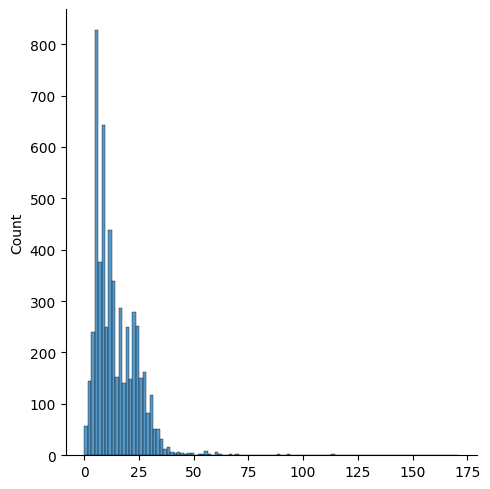

In [6]:
dist = [len(sample.split()) for sample in data["Sample"]]
sns.displot(dist)

## Feature Extraction

**Feature Extraction**: For this assignment, as instructed, I have implemented Bag-Of-Words and TFIDF features from scratch. The formula for TF-IDF is in the TF-IDF section below

#### Bag Of Words

In [7]:
# update vocabulary
vocabulary = set()
for sample in data["Sample"]: vocabulary.update(sample.split())

# extract bag of word feature matrix
bow_feature_matrix = []
for sample in data["Sample"]:
    bow = Counter(sample.split())
    bow_feature_matrix.append([bow[word] for word in vocabulary])

bow_data = pd.DataFrame(bow_feature_matrix, columns=list(vocabulary))
bow_data = pd.concat([bow_data, data["Class"]], axis=1)

In [8]:
print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 8431


#### TF-IDF

$$ \text{TF-IDF}(w, d) = \text{TF}(w, d) \times \text{IDF}(w) $$
$$ \text{where,} $$
$$ \text{TF}(w, d) = \text{term frequency of term t in document d} = \text{count}(w, d) $$
$$ \text{IDF}(w) = \text{inverse document frequency of term t in the document set D} = \log \left( \frac{N}{1 + \text{df}(w)} \right) $$

In [27]:
# calculate term frequency
tf_matrix = np.zeros([len(data), len(vocabulary)])
# num_rows = number of sentences
# num_columns = vocabulary size
for i, sample in enumerate(data["Sample"]):
    words = sample.split()
    word_counts = {word: words.count(word) for word in vocabulary}
    tf_matrix[i] = [word_counts[word] for word in vocabulary]

# calculate inverse document frequency
idf_matrix = np.zeros(len(vocabulary))
for j, word in enumerate(vocabulary):
    num_docs_containing_word = sum(1 for sentence in data["Sample"] if word in sentence.split())
    idf_matrix[j] = np.log(len(data) / (1 + num_docs_containing_word))

# calculate tfidf vectors
tfidf_matrix = tf_matrix * idf_matrix
tfidf_df = pd.DataFrame(tfidf_matrix, columns=list(vocabulary))
tfidf_data = pd.concat([tfidf_df, data["Class"]], axis=1)

## Model Training

Here, complement Naive Bayes did not have any hyperparameters that needed changing.

I trained a Complement Naive Bayes classifier (CNB) on both BoW and TF-IDF feature matrices.

#### Bag Of Words

generate samples for train and test using stratified sampling to keep same ratios of target classes in train and test

In [ ]:
X = bow_data.drop("Class", axis=1)
y = bow_data["Class"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

Accuracy: 0.96

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       966
        spam       0.78      0.97      0.87       149

    accuracy                           0.96      1115
   macro avg       0.89      0.97      0.92      1115
weighted avg       0.97      0.96      0.96      1115



[]

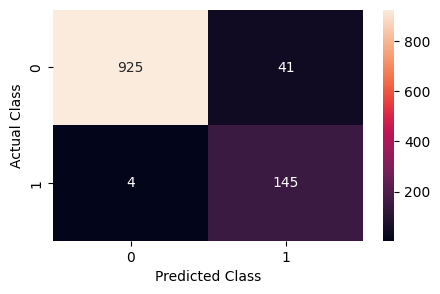

In [ ]:
cnb = ComplementNB().fit(x_train, y_train)
y_pred = cnb.predict(x_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}\n")
print(classification_report(y_pred=y_pred, y_true=y_test, zero_division=True))

cf_martix_df = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y_test))
plt.figure(figsize = (5,3))
heatmap = sns.heatmap(cf_martix_df, annot=True, fmt="g")
heatmap.set_xlabel("Predicted Class")
heatmap.set_ylabel("Actual Class")
plt.plot()

#### TF-IDF

generate samples for train and test using stratified sampling to keep same ratios of target classes in train and test

In [29]:
X = tfidf_data.drop("Class", axis=1)
y = tfidf_data["Class"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

Accuracy: 0.94

              precision    recall  f1-score   support

         ham       1.00      0.93      0.96       966
        spam       0.69      0.99      0.81       149

    accuracy                           0.94      1115
   macro avg       0.85      0.96      0.89      1115
weighted avg       0.96      0.94      0.94      1115



[]

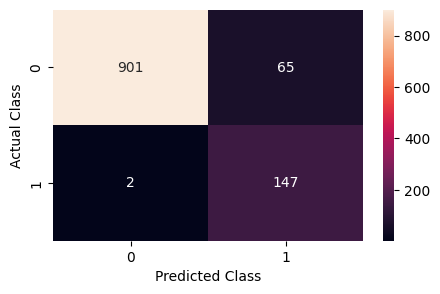

In [30]:
cnb = ComplementNB().fit(x_train, y_train)
y_pred = cnb.predict(x_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}\n")
print(classification_report(y_pred=y_pred, y_true=y_test, zero_division=True))

cf_martix_df = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y_test))
plt.figure(figsize = (5,3))
heatmap = sns.heatmap(cf_martix_df, annot=True, fmt="g")
heatmap.set_xlabel("Predicted Class")
heatmap.set_ylabel("Actual Class")
plt.plot()

**Findings**: we can observe that the Complement Naive Bayes Classifier did a slightly better job at classifying with BOW features compared to TF-IDF weighted features with an accuracy of 96% vs 94%

**Potential Improvements**: Performance can likely be improved by removing stop words and using the mode frequency instead of word count in the formula for TFIDF

### Additional Experiments *(5 additional points - <span style="color: red;">Optional</span>)*